In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1 - Loading in the Data

In [87]:
#Import data using np.loadtxt
clean_data = np.loadtxt('wifi_db/clean_dataset.txt')
noisy_data = np.loadtxt('wifi_db/noisy_dataset.txt')

In [88]:
#Explore clean data
print(clean_data)
print('length:', len(clean_data))
print('size:', clean_data.size)
print('shape:', clean_data.shape)

[[-64. -56. -61. ... -82. -81.   1.]
 [-68. -57. -61. ... -85. -85.   1.]
 [-63. -60. -60. ... -85. -84.   1.]
 ...
 [-62. -59. -46. ... -87. -88.   4.]
 [-62. -58. -52. ... -90. -85.   4.]
 [-59. -50. -45. ... -88. -87.   4.]]
length: 2000
size: 16000
shape: (2000, 8)


In [89]:
#Explore noisy data
print(noisy_data)
print('length:', len(noisy_data))
print('size:', noisy_data.size)
print('shape:', noisy_data.shape)

[[-59. -53. -51. ... -79. -87.   4.]
 [-66. -53. -59. ... -81. -79.   1.]
 [-41. -57. -63. ... -66. -65.   2.]
 ...
 [-57. -54. -56. ... -79. -82.   1.]
 [-56. -52. -50. ... -85. -88.   3.]
 [-46. -54. -47. ... -80. -73.   3.]]
length: 2000
size: 16000
shape: (2000, 8)


# Step 2 - Creating Decision trees

In [90]:
#Function to calculate information entropy - H(x)
def entropy(dataset):
    classes, counts = np.unique(dataset[:, -1], return_counts=True) #sorts y, and count number of each item in y
    probabilities = counts / len(classes) 
    return -np.sum(probabilities * np.log2(probabilities))

#Function to calculate information gain - IG
def information_gain(dataset, split_attribute, split_value): #
    left_split = dataset[dataset[:, split_attribute] <= split_value] #
    right_split = dataset[dataset[:, split_attribute] > split_value] #
    p_left = len(left_split)/len(dataset)
    p_right = len(right_split)/len(dataset)
    gain = entropy(dataset) - (p_left * entropy(left_split) + p_right * entropy(right_split))
    return gain

In [91]:

def calculate_information_gain(data, left_indices, right_indices):
    n_samples, n_features = data.shape
    n_classes = len(np.unique(data[:, -1]))
    
    # Calculate dataset entropy
    # We use np.bincount here for efficient counting of class occurrences:
  
    class_counts = np.bincount(data[:, -1].astype(int), minlength=n_classes)
    class_probs = class_counts / n_samples
    entropy_dataset = -np.sum(class_probs[class_probs > 0] * np.log2(class_probs[class_probs > 0])) #if class_probs > 0, then calculate entropy

    # Calculate entropy for left and right subsets
    left_class_counts = np.bincount(data[left_indices, -1].astype(int), minlength=n_classes)
    right_class_counts = np.bincount(data[right_indices, -1].astype(int), minlength=n_classes)
    
    left_probs = left_class_counts / len(left_indices)
    right_probs = right_class_counts / len(right_indices)
    
    entropy_left = -np.sum(left_probs[left_probs > 0] * np.log2(left_probs[left_probs > 0]))
    entropy_right = -np.sum(right_probs[right_probs > 0] * np.log2(right_probs[right_probs > 0]))

    # Calculate the remainder
    remainder = (len(left_indices) * entropy_left + len(right_indices) * entropy_right) / n_samples

    # Calculate the information gain
    information_gain = entropy_dataset - remainder

    return information_gain

def find_split(data):
    n_samples, n_features = data.shape
    best_gain = -float('inf')
    best_split = None
    best_feature = None

    for feature in range(n_features - 1):  # Exclude the last column (labels)
        # Sort the data by the current feature
        sorted_indices = data[:, feature].argsort()
        sorted_data = data[sorted_indices]

        # Consider only split points between two examples in sorted order
        for i in range(1, n_samples):
            if sorted_data[i, feature] != sorted_data[i-1, feature]:
                split_point = (sorted_data[i-1, feature] + sorted_data[i, feature]) / 2

                # Calculate the information gain
                left_indices = sorted_indices[:i]
                right_indices = sorted_indices[i:]
                gain = calculate_information_gain(data, left_indices, right_indices)

                # Update best split if necessary
                if gain > best_gain:
                    best_gain = gain
                    best_split = split_point
                    best_feature = feature

    return best_feature, best_split

# Update the print statement
print(find_split(clean_data))


(0, -54.5)


In [92]:
def decision_tree_learning(dataset, depth=0):
    labels = dataset[:, -1]  # Last column is the label
    
    # Base case: if all labels are the same, return a leaf node
    if len(np.unique(labels)) == 1:
        return {'label': labels[0], 'depth': depth}
    
    # Otherwise, find the best split
    attribute, value = find_split(dataset) 
    if attribute is None:
        # If no split is possible, return a leaf with the majority label
        unique, counts = np.unique(labels, return_counts=True)
        majority_label = unique[np.argmax(counts)]
        return {'label': majority_label, 'depth': depth}
    
    # Split the dataset
    left_split = dataset[dataset[:, attribute] <= value]
    right_split = dataset[dataset[:, attribute] > value]
    
    # Create a new decision node
    tree = {
        'attribute': attribute,
        'value': value,
        'depth': depth,
        'left': decision_tree_learning(left_split, depth + 1),
        'right': decision_tree_learning(right_split, depth + 1)
    }
    
    return tree


In [93]:
def plot_tree(tree, depth=0, pos=None, parent_pos=None, ax=None, x_offset=0.5, y_offset=1.0):
    if pos is None:
        pos = {id(tree): (0.5, 1.0)}  # The root is centered at (0.5, 1.0)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_axis_off()  # Hide axis
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

    # Draw connection between parent node and current node
    if parent_pos is not None:
        ax.plot([parent_pos[0], pos[id(tree)][0]], [parent_pos[1], pos[id(tree)][1]], 'k-', lw=2)  # Draw line
    
    # Check if it is a leaf node
    if 'label' in tree:
        node_text = f"Leaf\nLabel: {tree['label']}\nDepth: {tree['depth']}"
        ax.text(pos[id(tree)][0], pos[id(tree)][1], node_text, ha='center', va='center', 
                bbox=dict(facecolor='lightgreen', edgecolor='black'))
    else:
        # Not a leaf node, plot attribute and split value
        node_text = f"Node\nAttr: {tree['attribute']}\nVal: {tree['value']}\nDepth: {tree['depth']}"
        ax.text(pos[id(tree)][0], pos[id(tree)][1], node_text, ha='center', va='center', 
                bbox=dict(facecolor='lightblue', edgecolor='black'))

    # Plot the left and right children
    left_child = tree.get('left')
    right_child = tree.get('right')

    if left_child is not None:
        # Set position for the left child
        pos[id(left_child)] = (pos[id(tree)][0] - x_offset / (depth + 1), pos[id(tree)][1] - y_offset)
        plot_tree(left_child, depth + 1, pos, pos[id(tree)], ax, x_offset, y_offset)

    if right_child is not None:
        # Set position for the right child
        pos[id(right_child)] = (pos[id(tree)][0] + x_offset / (depth + 1), pos[id(tree)][1] - y_offset)
        plot_tree(right_child, depth + 1, pos, pos[id(tree)], ax, x_offset, y_offset)

    # If it's the root call, show the plot
    if parent_pos is None:
        plt.show()

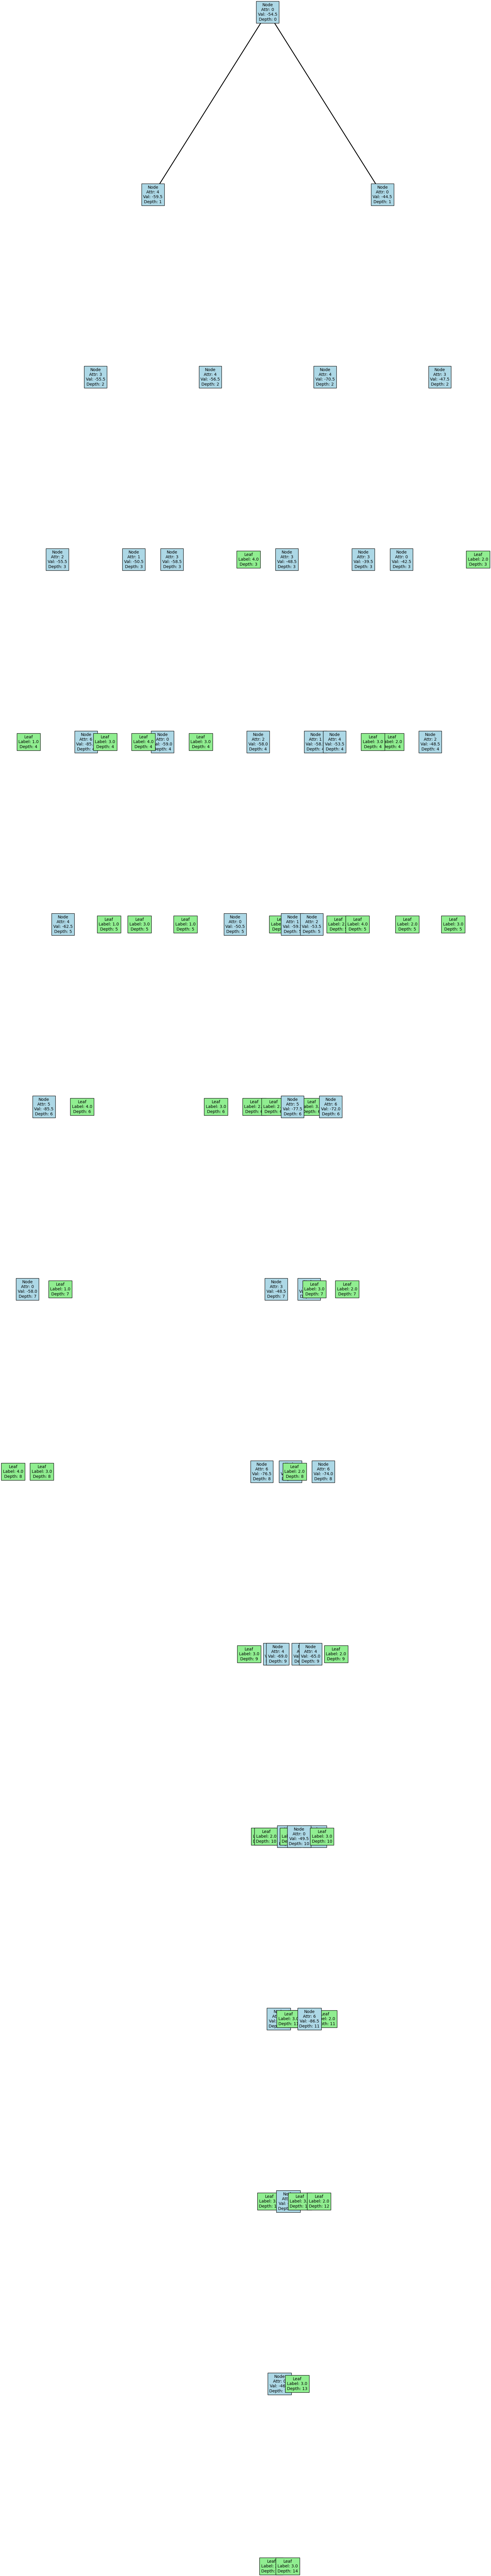

In [94]:
tree = decision_tree_learning(clean_data)
#tree = decision_tree_learning(noisy_data)
plot_tree(tree)

Evaluation metrics something's wrong with the confusion matrix I somehow fucked it up because im getting 1000% accuracies with 100 recall 100 precision etc. 

In [95]:
#function to perform 10-fold cross validation
def cross_validation(data, n_folds=10):
    np.random.shuffle(data)
    fold_size = len(data) // n_folds
    accuracies = []

    for i in range(n_folds):
        # Split data into training and validation sets
        start = i * fold_size
        end = start + fold_size if i < n_folds - 1 else len(data)
        validation_data = data[start:end]
        training_data = np.concatenate([data[:start], data[end:]])

        # Train the decision tree
        tree = decision_tree_learning(training_data)

        # Evaluate the tree on validation data
        correct_predictions = 0
        for sample in validation_data:
            prediction = predict(tree, sample[:-1])
            if prediction == sample[-1]:
                correct_predictions += 1

        accuracy = correct_predictions / len(validation_data)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    return mean_accuracy, std_accuracy

def predict(tree, sample):
    if 'label' in tree:
        return tree['label']
    
    if sample[tree['attribute']] <= tree['value']:
        return predict(tree['left'], sample)
    else:
        return predict(tree['right'], sample)

# Perform 10-fold cross-validation for clean data
mean_accuracy, std_accuracy = cross_validation(clean_data)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")


Mean Accuracy: 0.9705
Standard Deviation of Accuracy: 0.0096


In [96]:
#10-fold cross validation for noisy data 
mean_accuracy, std_accuracy = cross_validation(noisy_data)
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

Mean Accuracy: 0.8015
Standard Deviation of Accuracy: 0.0307


In [97]:
def compute_confusion_matrix(data, tree):
    # Get unique class labels
    unique_labels = np.unique(data[:, -1]).astype(int)
    n_classes = len(unique_labels)
    
    # Create a mapping from original labels to 0-indexed labels
    label_map = {label: i for i, label in enumerate(unique_labels)}
    
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
    
    for sample in data:
        true_label = int(sample[-1])
        predicted_label = int(predict(tree, sample[:-1]))
        
        # Map the labels to 0-indexed positions
        true_index = label_map[true_label]
        pred_index = label_map[predicted_label]
        
        confusion_matrix[true_index, pred_index] += 1
    
    return confusion_matrix, unique_labels

def print_confusion_matrix(confusion_matrix, labels):
    n_classes = confusion_matrix.shape[0]
    print("Confusion Matrix:")
    print("    ", end="")
    for label in labels:
        print(f"{label:4}", end="")
    print("\n    " + "-" * (4 * n_classes))
    
    for i, label in enumerate(labels):
        print(f"{label:2} |", end="")
        for j in range(n_classes):
            print(f"{confusion_matrix[i, j]:4}", end="")
        print()
    print()

# Compute and print confusion matrix for clean data
clean_tree = decision_tree_learning(clean_data)
clean_confusion_matrix, clean_labels = compute_confusion_matrix(clean_data, clean_tree)
print("Clean Data:")
print_confusion_matrix(clean_confusion_matrix, clean_labels)

# Compute and print confusion matrix for noisy data
noisy_tree = decision_tree_learning(noisy_data)
noisy_confusion_matrix, noisy_labels = compute_confusion_matrix(noisy_data, noisy_tree)
print("Noisy Data:")
print_confusion_matrix(noisy_confusion_matrix, noisy_labels)

Clean Data:
Confusion Matrix:
       1   2   3   4
    ----------------
 1 | 500   0   0   0
 2 |   0 500   0   0
 3 |   0   0 500   0
 4 |   0   0   0 500

Noisy Data:
Confusion Matrix:
       1   2   3   4
    ----------------
 1 | 490   0   0   0
 2 |   0 497   0   0
 3 |   0   0 515   0
 4 |   0   0   0 498



In [98]:
def calculate_accuracy(confusion_matrix):
    total_samples = np.sum(confusion_matrix)
    correct_predictions = np.sum(np.diag(confusion_matrix))
    accuracy = correct_predictions / total_samples
    return accuracy

# Calculate and print accuracy for clean data
clean_accuracy = calculate_accuracy(clean_confusion_matrix)
print(f"Clean Data Accuracy: {clean_accuracy:.4f}")

# Calculate and print accuracy for noisy data
noisy_accuracy = calculate_accuracy(noisy_confusion_matrix)
print(f"Noisy Data Accuracy: {noisy_accuracy:.4f}")


Clean Data Accuracy: 1.0000
Noisy Data Accuracy: 1.0000


In [99]:
def calculate_recall(confusion_matrix):
    recalls = []
    for i in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[i, i]
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        recalls.append(recall)
    return np.array(recalls)

# Calculate and print recall for clean data
clean_recalls = calculate_recall(clean_confusion_matrix)
print("Clean Data Recalls:")
for i, recall in enumerate(clean_recalls):
    print(f"Class {clean_labels[i]}: {recall:.4f}")
print(f"Average Recall: {np.mean(clean_recalls):.4f}")

print("\n")

# Calculate and print recall for noisy data
noisy_recalls = calculate_recall(noisy_confusion_matrix)
print("Noisy Data Recalls:")
for i, recall in enumerate(noisy_recalls):
    print(f"Class {noisy_labels[i]}: {recall:.4f}")
print(f"Average Recall: {np.mean(noisy_recalls):.4f}")


Clean Data Recalls:
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Average Recall: 1.0000


Noisy Data Recalls:
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Average Recall: 1.0000


In [100]:
def calculate_precision(confusion_matrix):
    precisions = []
    for i in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        precisions.append(precision)
    return np.array(precisions)

# Calculate and print precision for clean data
clean_precisions = calculate_precision(clean_confusion_matrix)
print("Clean Data Precisions:")
for i, precision in enumerate(clean_precisions):
    print(f"Class {clean_labels[i]}: {precision:.4f}")
print(f"Average Precision: {np.mean(clean_precisions):.4f}")

print("\n")

# Calculate and print precision for noisy data
noisy_precisions = calculate_precision(noisy_confusion_matrix)
print("Noisy Data Precisions:")
for i, precision in enumerate(noisy_precisions):
    print(f"Class {noisy_labels[i]}: {precision:.4f}")
print(f"Average Precision: {np.mean(noisy_precisions):.4f}")


Clean Data Precisions:
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Average Precision: 1.0000


Noisy Data Precisions:
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Average Precision: 1.0000


In [101]:
def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Calculate F1 scores for clean data
clean_f1_scores = [calculate_f1_score(p, r) for p, r in zip(clean_precisions, clean_recalls)]
print("Clean Data F1 Scores:")
for i, f1_score in enumerate(clean_f1_scores):
    print(f"Class {clean_labels[i]}: {f1_score:.4f}")
print(f"Average F1 Score: {np.mean(clean_f1_scores):.4f}")

print("\n")

# Calculate F1 scores for noisy data
noisy_f1_scores = [calculate_f1_score(p, r) for p, r in zip(noisy_precisions, noisy_recalls)]
print("Noisy Data F1 Scores:")
for i, f1_score in enumerate(noisy_f1_scores):
    print(f"Class {noisy_labels[i]}: {f1_score:.4f}")
print(f"Average F1 Score: {np.mean(noisy_f1_scores):.4f}")


Clean Data F1 Scores:
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Average F1 Score: 1.0000


Noisy Data F1 Scores:
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Average F1 Score: 1.0000
